In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import cv2
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 15
# GPU out of memory: batch size 256 -> 128 -> 64 -> 32
batchsize = 32
# set random seed
seed = 7777
# initialize values
best_acc = 0

In [3]:
food_class = {
    0: 'bread',
    1: 'butter',
    2: 'dessert',
    3: 'egg',
    4: 'fries',
    5: 'meat',
    6: 'noodle',
    7: 'rice',
    8: 'seafood',
    9: 'soup',
    10: 'vegetables or fruits'
}

In [4]:
# apply seed
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [5]:
def loadImages(imagesList, list_label, max_size):
    for temp_size, each_image in enumerate(imagesList):
        if temp_size >= max_size:
            break
        
        image_name = os.path.split(each_image)[-1]
        class_name = image_name.split('_')[0]
        classes.append(class_name)

        image = img.imread(each_image)
        imgplot = plt.imshow(image)
        plt.show()

        print(food_class[list_label[temp_size]])

In [6]:
train_path = '../input/ml2022spring-hw3b/food11/training'
training = glob(f'{train_path}/*.jpg')
classes = []

for each_image in training:
    image_name = os.path.split(each_image)[-1]
    class_name = image_name.split('_')[0]
    classes.append(class_name)

for i in range(0, len(classes)):
    classes[i] = int(classes[i])

print(np.unique(classes))

[ 0  1  2  3  4  5  6  7  8  9 10]


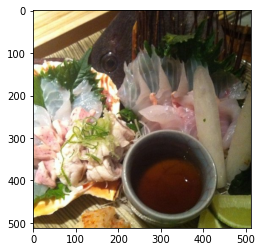

seafood


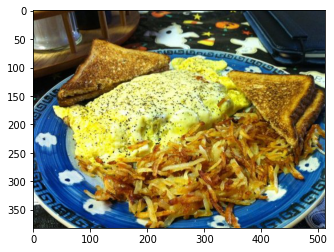

egg


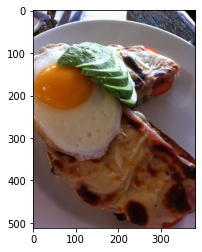

egg


In [7]:
loadImages(training, classes, 3)

In [8]:
# transforms for image augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=1.5, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# normally test and validation do not need augmentations,
# but image sizes have to be equal to the train ones, so do resize only
test_valid_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [9]:
# have to return the original image and it's label
class CustomDataset(Dataset):
    def __init__(self, path, test=False, transform=test_valid_transform):
        self.base_path = path
        self.path = glob(f'{path}/*.jpg') # the path of each image
        self.files = [os.path.split(each_path)[-1] for each_path in self.path] # total name of images
        self.test = test
        self.transform = transform
    
    def __getitem__(self, idx):
        file_name = self.files[idx]
        image = Image.open(f'{self.base_path}/{file_name}')
        # if apply transform
        image = self.transform(image)
        image = np.array(image) # change jpg image to NumPy arrays
        if self.test == True:
            label = -1 # test images has no label
        label = file_name.split('_')[0]
        return image, label
        
    def __len__(self):
        return len(self.files)

CNN network: Residual model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # input = [3, 256, 256]; [image channel, image width, image height]
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 128, 3),
            nn.BatchNorm2d(128),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3),
            nn.BatchNorm2d(512),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, 3),
            nn.BatchNorm2d(1024),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3),
            nn.BatchNorm2d(1024),
        )
        self.fc1 = nn.Linear(1024*8*8, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 11)

    def forward(self, x):
        x = F.adaptive_max_pool2d(F.relu(self.conv1(x)), (128, 128))
        x = F.adaptive_max_pool2d(F.relu(self.conv2(x)), (64, 64))
        x = F.adaptive_max_pool2d(F.relu(self.conv3(x)), (32, 32))
        x = F.adaptive_max_pool2d(F.relu(self.conv4(x)), (16, 16))
        x = F.adaptive_max_pool2d(F.relu(self.conv5(x)), (8, 8))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Dataloader

In [11]:
train_path = '../input/ml2022spring-hw3b/food11/training'
valid_path = '../input/ml2022spring-hw3b/food11/validation'

# pin_memory = True to speed up the host to device transfer when pushing dataset to GPU
train_dataset = CustomDataset(train_path, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, pin_memory=True)
valid_dataset = CustomDataset(valid_path, transform=test_valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=True, pin_memory=True)

# use GPU to speed up the image training
model = CNN().to(device)

# define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

Training

In [12]:
def convert_str_int(list):
    for i in range(0, len(list)):
        list[i] = int(list[i])
        
    return list

In [13]:
# repeat training for 4 times of epoch
for epoch in range(n_epochs):
    model.train() # Set model to train mode
    
    train_loss = []
    train_accs = []
    
    # [images, labels] get the processed from train loader
    for images, labels in tqdm(train_loader):
        labels = convert_str_int(labels)
        labels = torch.FloatTensor(labels)
        labels = labels.type(torch.LongTensor)
        
        # set the gradient to 0 at initial
        optimizer.zero_grad()

        # forward data, making sure the data and model are on the same device
        outputs = model(images.to(device)) # feature map
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for images, labels in tqdm(valid_loader):
        labels = convert_str_int(labels)
        labels = torch.FloatTensor(labels)
        labels = labels.type(torch.LongTensor)
        
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            outputs = model(images.to(device))
        
        loss = criterion(outputs, labels.to(device))
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # update logs
    if valid_acc > best_acc:
        with open(f"./CNN_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./CNN_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"CNN_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc

100%|██████████| 309/309 [09:20<00:00,  1.81s/it]


[ Train | 001/004 ] loss = 2.18034, acc = 0.22067


100%|██████████| 108/108 [01:28<00:00,  1.23it/s]


[ Valid | 001/004 ] loss = 1.97408, acc = 0.29253
[ Valid | 001/004 ] loss = 1.97408, acc = 0.29253 -> best
Best model found at epoch 0, saving model


100%|██████████| 309/309 [08:25<00:00,  1.64s/it]


[ Train | 002/004 ] loss = 1.97834, acc = 0.29608


100%|██████████| 108/108 [01:09<00:00,  1.55it/s]


[ Valid | 002/004 ] loss = 1.84422, acc = 0.33989
[ Valid | 002/004 ] loss = 1.84422, acc = 0.33989 -> best
Best model found at epoch 1, saving model


100%|██████████| 309/309 [08:23<00:00,  1.63s/it]


[ Train | 003/004 ] loss = 1.86822, acc = 0.33916


100%|██████████| 108/108 [01:08<00:00,  1.58it/s]


[ Valid | 003/004 ] loss = 1.79493, acc = 0.37963
[ Valid | 003/004 ] loss = 1.79493, acc = 0.37963 -> best
Best model found at epoch 2, saving model


100%|██████████| 309/309 [09:13<00:00,  1.79s/it]


[ Train | 004/004 ] loss = 1.75545, acc = 0.38782


100%|██████████| 108/108 [01:55<00:00,  1.07s/it]


[ Valid | 004/004 ] loss = 1.63598, acc = 0.42988
[ Valid | 004/004 ] loss = 1.63598, acc = 0.42988 -> best
Best model found at epoch 3, saving model


In [14]:
PATH = './CNN_best.ckpt'
torch.save(model.state_dict(), PATH)

testing

In [15]:
def predict(test_loader, model, device):
    prediction = []
    with torch.no_grad():
        for data, _ in test_loader:
            test_pred = model(data.to(device))
            # get the maximum predicted value: that will be the test image's class
            test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
            prediction += test_label.squeeze().tolist()
    return prediction

In [16]:
test_path = '../input/ml2022spring-hw3b/food11/test'
test_dataset = CustomDataset(test_path, test=True, transform=test_valid_transform)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False, pin_memory=True)

model_best = CNN().to(device)
model_best.load_state_dict(torch.load('./CNN_best.ckpt'))
model_best.eval()

preds = predict(test_loader, model_best, device)

In [21]:
testing_print_n = 4
testing = glob(f'{test_path}/*.jpg')

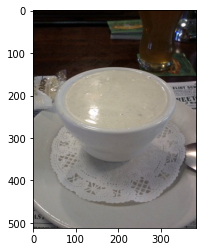

soup


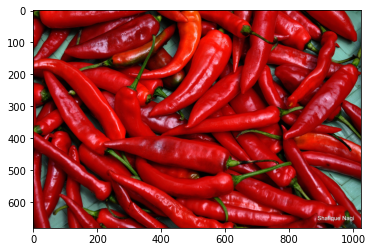

vegetables or fruits


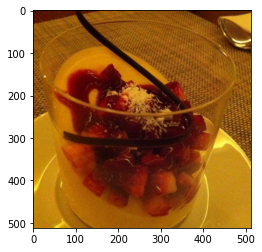

meat


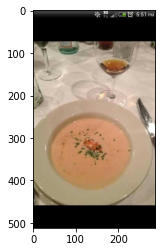

soup


In [22]:
loadImages(testing, preds, testing_print_n)